<a href="https://colab.research.google.com/github/SamuelBFG/ga-fading/blob/main/DEAP_KappaMu_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genetic Algorithms: $\kappa$-$\mu$ fading distribution parameter estimation using deap.


In [1]:
!pip install deap

In [2]:
from scipy import special as sp
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import gaussian_kde as kdf

class KappaMu():
    "KappaMu fading distribution"
    # r = np.linspace(0, 3, 3000) # theoretical envelope PDF x axes
    def __init__(self, kappa, mu, r_hat, numSamples, numSim):
      # Parameters
      self.kappa = kappa
      self.mu = mu
      self.r_hat = r_hat  
      self.numSamples = numSamples
      self.numSim = numSim

      # For simulated densities
      self.generateSamples = self.generateSamples()
      self.X, self.Y = self.envelopeDensity(self.numSamples)

    def _pdf(self, r):
      A = (2*self.mu * ((1 + self.kappa)**((self.mu+1)/2))) \
              /((self.kappa**((self.mu - 1)/2)) * np.exp(self.mu * self.kappa))
      R = r / self.r_hat
      B = (R**self.mu) * np.exp(- self.mu*(1 + self.kappa)*(R**2))
      C = sp.iv(self.mu - 1, 2*self.mu * R * np.sqrt(self.kappa*(1 + self.kappa)))
      PDF = A * B * C / self.r_hat 
      return PDF

    def scatteredComponent(self):
      # scattered_Component calculates the power of the scattered signal component
    
      sigma = self.r_hat / np.sqrt( 2 * self.mu * (1+self.kappa) )
    
      return sigma

    def generate_Gaussians(self, mean, sigma):
      # generate_Gaussians generates the Gaussian random variables
      gaussians = np.random.default_rng().normal(mean, sigma, self.numSim)
        
      return gaussians

    def generateSamples(self):
      # Generates complex fading random variables
      
      p_i, q_i = self.calculateMeans()
      sigma = self.scatteredComponent()
      
      fading = 0
      for i in range(int(self.mu)):
          X_i = self.generate_Gaussians(p_i, sigma)
          Y_i = self.generate_Gaussians(q_i, sigma)
          fading = fading + X_i**(2) + Y_i**(2)  
      return fading

    def calculateMeans(self):
    # calculate_means calculates the means of the complex Gaussians representing the
    # in-phase and quadrature components
    
      d2 = (self.r_hat**(2) * self.kappa)/(1 + self.kappa);
    
      p_i = np.sqrt(d2/(2*self.mu))
      q_i = np.copy(p_i)
        
      return p_i, q_i

    def envelopeDensity(self, numSamples):
      '''
      Function for returning X and Y axes for each
      densities for each simulated sample
      '''
        # envelopeDensity finds the envelope PDF of the simulated random variables
        
      R = np.sqrt(self.generateSamples)
      kde = kdf(R)
      x = np.linspace(R.min(), R.max(), numSamples)
      y = kde(x)
      
      return x, y


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy import special as sp
import deap
from deap import algorithms, base, creator, tools
# from KappaMu import KappaMu

import seaborn as sns
sns.set(style='whitegrid')
sns.set_context('notebook')

def evaluation(theta):
  X = np.array([1,2,3,4,5,20,26,7])
  Y = np.array([5,7,9,11,13,43,55,17])

  n = len(X)
  y_pred = theta[0]*X + theta[1]
  cost = 1/n * sum(val**2 for val in (Y-y_pred))
  return (cost,)

def computePDF(r, kappa, mu, r_hat):
  A = (2*mu * ((1 + kappa)**((mu+1)/2))) \
          /((kappa**((mu - 1)/2)) * np.exp(mu * kappa))
  R = r / r_hat
  B = (R**mu) * np.exp(- mu*(1 + kappa)*(R**2))
  C = sp.iv(mu - 1, 2*mu * R * np.sqrt(kappa*(1 + kappa)))
  PDF = A * B * C / r_hat 
  return PDF

def fitnessFunction(theta):
  # X = np.array([1,2,3,4,5,20,26,7])
  # Y = np.array([5,7,9,11,13,43,55,17])
  X = ku.X
  Y = ku.Y
  n = len(X)
  kappa = theta[0]
  mu = theta[1]
  r_hat = theta[2]

  y_pred = computePDF(X, kappa, mu, r_hat)
  # print('y_pred', y_pred)
  # y_pred = theta[0]*X + theta[1]
  cost = 1/n * sum(val**2 for val in (Y-y_pred))
  return (cost,)

In [4]:
### PARAMETERS

kappa = 1
mu = 4
r_hat = 1
numSamples = 100
numSim = 10**6
theta = [kappa, mu, r_hat]

In [5]:
ku = KappaMu(kappa, mu, r_hat, numSamples, numSim)

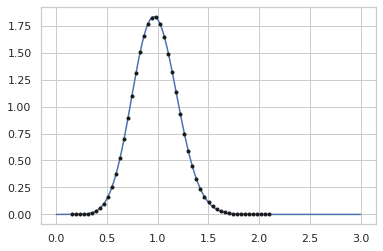

In [6]:
r = np.linspace(0, 3, 3000) # theoretical envelope PDF x axes
plt.figure(figsize=((10,7)))
plt.plot(r, ku._pdf(r))
plt.plot(ku.X[1:len(ku.X):2], ku.Y[1:len(ku.Y):2], "k.", label='Simulation')

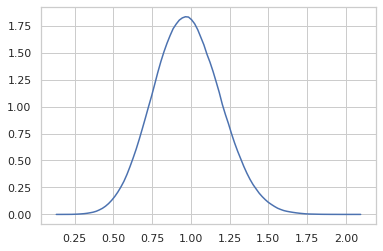

In [8]:
plt.plot(ku.X,ku.Y)

In [9]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) #-1 to minimze, +1 to maximize
creator.create("Individual", list, fitness=creator.FitnessMin)

# toolbox = base.Toolbox()

### One individual for each $\hat{\theta}_i$


In [10]:
toolbox = base.Toolbox()

In [11]:
toolbox.register("attr_bool", np.random.uniform, 0.1, 3)
toolbox.attr_bool()

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
print('random individual')
toolbox.individual()

random individual


[2.228095621781484, 1.06326654696946, 2.4265162217788454]

In [12]:
toolbox.register("evaluate", fitnessFunction)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=1, sigma= 0.5, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

In [13]:
pop = toolbox.population(n=500)

In [14]:
hof = tools.ParetoFront()

In [15]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [16]:
# sortedPop = sorted(pop, key=lambda ind:ind.fitness)

In [17]:
pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.3,\
                               ngen=100, stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg     	std     	min       	max    
0  	500   	0.704489	0.627457	0.00236334	4.49317
1  	315   	0.355534	0.210712	0.00236334	1.49263
2  	320   	0.205506	0.155279	0.0019326 	0.805975
3  	328   	0.107655	0.120361	0.00150288	0.764079
4  	339   	0.0526097	0.103159	0.00150288	0.84698 
5  	359   	0.0313206	0.106582	0.000219559	0.891465
6  	357   	0.0295138	0.123207	0.000199242	0.788416
7  	342   	0.0280719	0.126484	0.000199242	0.903149
8  	335   	0.0232104	0.120959	0.00018113 	0.836378
9  	307   	0.0262606	0.131655	0.00018113 	0.908176
10 	319   	0.0218172	0.118581	0.000180351	0.864284
11 	298   	0.0210713	0.117159	0.000180351	0.790576
12 	327   	0.0197006	0.108986	5.74756e-05	0.782725
13 	308   	0.0157161	0.100401	5.74756e-05	0.799464
14 	314   	0.0207158	0.118292	5.74756e-05	0.824876
15 	321   	0.0320297	0.145541	5.32529e-05	0.820335
16 	341   	0.029227 	0.140383	5.32529e-05	0.902988
17 	322   	0.0281739	0.135493	5.32529e-05	0.976645
18 	316   	0.0284373	0.14002 	5.32529e-05	0.8

In [18]:
print('Current best fitness:', fitnessFunction(tools.selBest(pop, k=1)[0]))

Current best fitness: (5.271788207721783e-05,)


In [19]:
print('Estimated parameters: ')
hof[0]

Estimated parameters: 


[2.2355981574921495, 2.7892639456420083, 0.9966031862143702]

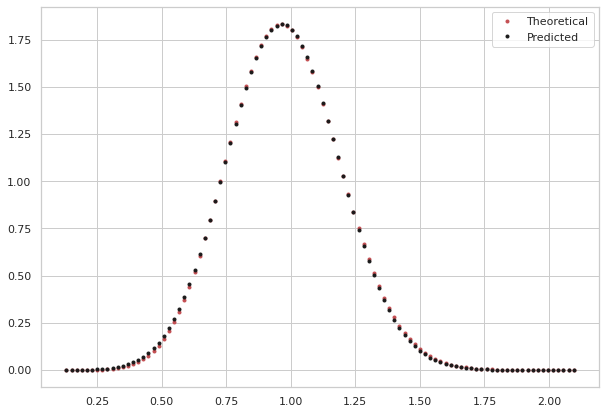

In [20]:
kappa = theta[0]
mu = theta[1]
r_hat = theta[2]
X = ku.X
Y = ku.Y
y_pred = computePDF(X, kappa, mu, r_hat)

plt.figure(figsize=(10,7))
plt.plot(X, y_pred,'.r', label='Theoretical')
plt.plot(X, computePDF(X,hof[0][0],hof[0][1],hof[0][2]),'.k', label='Predicted')
plt.legend()
plt.show()

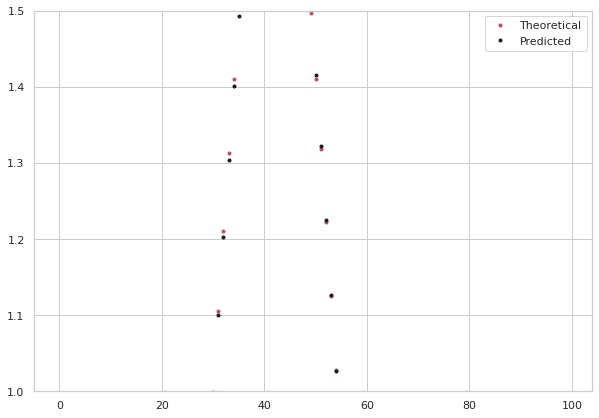

In [21]:
plt.figure(figsize=(10,7))
plt.plot(y_pred,'.r', label='Theoretical')
plt.plot(computePDF(ku.X,hof[0][0],hof[0][1],hof[0][2]),'.k', label='Predicted')
plt.ylim((1,1.5))
plt.legend()
plt.show()

In [22]:
len(hof)

1

In [23]:
print(r'$\theta_0$ is {}, $\theta_1$ is {} and $\theta_1$ is {}.'.format(hof.items[0][0], hof.items[0][1], hof.items[0][2]))
print('kappa={} mu={} r_hat={}'.format(theta[0], theta[1], theta[2]))

$\theta_0$ is 2.2355981574921495, $\theta_1$ is 2.7892639456420083 and $\theta_1$ is 0.9966031862143702.
kappa=1 mu=4 r_hat=1


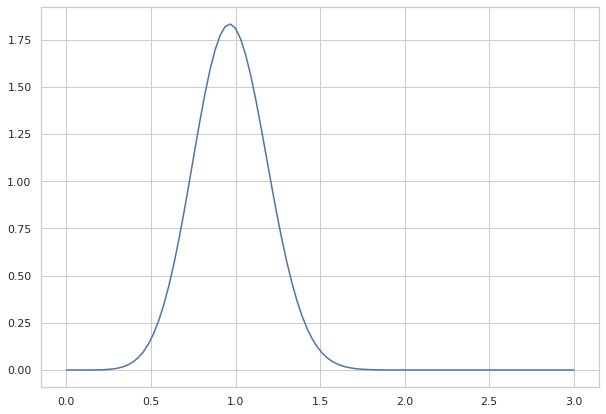

In [33]:
x_test = np.linspace(0+1e-4,3,100)
plt.figure(figsize=((10,7)))

plt.plot(x_test, computePDF(x_test, kappa=hof.items[0][0], mu=hof.items[0][1], r_hat=hof.items[0][2]),label=r'$\mu=0.5$')

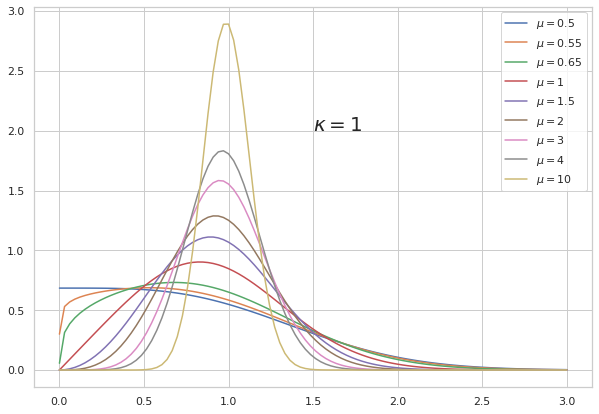

In [24]:
x_test = np.linspace(0+1e-4,3,100)
plt.figure(figsize=((10,7)))

plt.plot(x_test, computePDF(x_test, kappa=1, mu=0.5, r_hat=1),label=r'$\mu=0.5$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=0.55, r_hat=1),label=r'$\mu=0.55$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=0.65, r_hat=1),label=r'$\mu=0.65$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=1, r_hat=1),label=r'$\mu=1$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=1.5, r_hat=1),label=r'$\mu=1.5$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=2, r_hat=1),label=r'$\mu=2$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=3, r_hat=1),label=r'$\mu=3$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=4, r_hat=1),label=r'$\mu=4$')
plt.plot(x_test, computePDF(x_test, kappa=1, mu=10, r_hat=1),label=r'$\mu=10$')
plt.text(x=1.5, y=2, s=r'$\kappa=1$', size=20)
plt.legend()
plt.show()

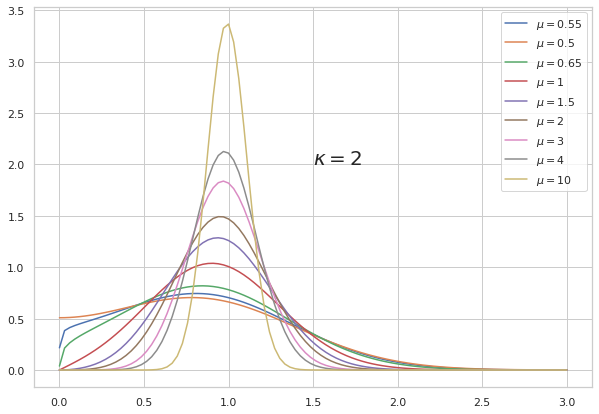

In [25]:
x_test = np.linspace(0+1e-4,3,100)

plt.figure(figsize=((10,7)))
plt.plot(x_test, computePDF(x_test, kappa=2, mu=0.55, r_hat=1),label=r'$\mu=0.55$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=0.5, r_hat=1),label=r'$\mu=0.5$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=0.65, r_hat=1),label=r'$\mu=0.65$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=1, r_hat=1),label=r'$\mu=1$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=1.5, r_hat=1),label=r'$\mu=1.5$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=2, r_hat=1),label=r'$\mu=2$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=3, r_hat=1),label=r'$\mu=3$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=4, r_hat=1),label=r'$\mu=4$')
plt.plot(x_test, computePDF(x_test, kappa=2, mu=10, r_hat=1),label=r'$\mu=10$')
plt.text(x=1.5, y=2, s=r'$\kappa=2$', size=20)
plt.legend()
plt.show()

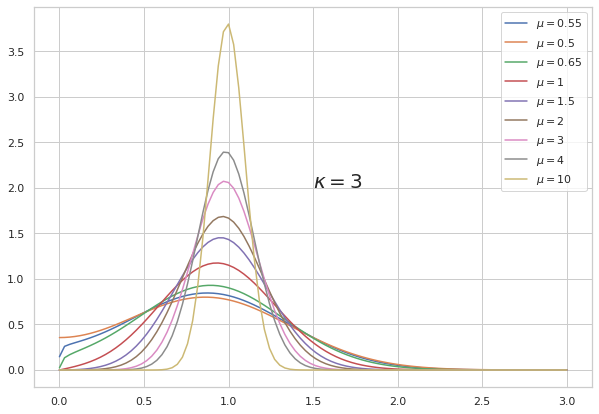

In [26]:
x_test = np.linspace(0+1e-4,3,100)

plt.figure(figsize=((10,7)))
plt.plot(x_test, computePDF(x_test, kappa=3, mu=0.55, r_hat=1),label=r'$\mu=0.55$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=0.5, r_hat=1),label=r'$\mu=0.5$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=0.65, r_hat=1),label=r'$\mu=0.65$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=1, r_hat=1),label=r'$\mu=1$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=1.5, r_hat=1),label=r'$\mu=1.5$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=2, r_hat=1),label=r'$\mu=2$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=3, r_hat=1),label=r'$\mu=3$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=4, r_hat=1),label=r'$\mu=4$')
plt.plot(x_test, computePDF(x_test, kappa=3, mu=10, r_hat=1),label=r'$\mu=10$')
plt.text(x=1.5, y=2, s=r'$\kappa=3$', size=20)
plt.legend()
plt.show()

In [ ]:
data = pd.read_csv('/content/pathAB_SSF_dB_AP8_downsampled1Khz_win50.txt')

In [ ]:
data.describe()

In [ ]:
data.plot()

In [ ]:
data = np.sqrt(data)
data.describe()

In [ ]:
data.plot()

In [ ]:
sns.distplot(data)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.plot()

In [ ]:
sns.distplot(data)

In [ ]:
data2 = data.copy()
data = []
for idx, var in enumerate(list(data2)):
    myPlot = sns.distplot(data2[var])
    
    # Fine Line2D objects
    lines2D = [obj for obj in myPlot.findobj() if str(type(obj)) == "<class 'matplotlib.lines.Line2D'>"]
    
    # Retrieving x, y data
    x, y = lines2D[idx].get_data()[0], lines2D[idx].get_data()[1]
    
    # Store as dataframe 
    data.append(pd.DataFrame({'x':x, 'y':y}))

In [ ]:
data3 = data[0]['x'][data[0]['x'] > 0]

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) #-1 to minimze, +1 to maximize
creator.create("Individual", list, fitness=creator.FitnessMin)

# toolbox = base.Toolbox()

### One individual for each $\hat{\theta}_i$


In [ ]:
toolbox2 = base.Toolbox()

In [ ]:
toolbox2.register("attr_bool", np.random.uniform, 0.1, 5)
toolbox2.attr_bool()

toolbox2.register("individual", tools.initRepeat, creator.Individual, toolbox2.attr_bool, 3)
toolbox2.register("population", tools.initRepeat, list, toolbox2.individual)
toolbox2.individual()

In [ ]:
toolbox2.register("evaluate", fitnessFunction)
toolbox2.register("mate", tools.cxTwoPoint)
toolbox2.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox2.register("select", tools.selTournament, tournsize=3)

In [ ]:
pop2 = toolbox2.population(n=500)

In [ ]:
hof2 = tools.ParetoFront()

In [ ]:
stats2 = tools.Statistics(lambda ind: ind.fitness.values)
stats2.register("avg", np.mean)
stats2.register("std", np.std)
stats2.register("min", np.min)
stats2.register("max", np.max)

In [ ]:
def fitnessFunction(theta):
  # X = np.array([1,2,3,4,5,20,26,7])
  # Y = np.array([5,7,9,11,13,43,55,17])
  X = data3[0]['x']
  Y = data3[0]['y']
  n = len(X)
  kappa = theta[0]
  mu = theta[1]
  r_hat = theta[2]

  y_pred = computePDF(X, kappa, mu, r_hat)
  # print('y_pred', y_pred)
  # y_pred = theta[0]*X + theta[1]
  cost = 1/n * sum(val**2 for val in (Y-y_pred))
  return (cost,)

In [ ]:
pop, log = algorithms.eaSimple(pop2, toolbox2, cxpb=0.5, mutpb=0.2,\
                               ngen=100, stats=stats2, halloffame=hof2, verbose=True)

In [ ]:
print(r'$\theta_0$ is {}, $\theta_1$ is {} and $\theta_1$ is {}.'.format(hof.items[0][0], hof.items[0][1], hof.items[0][2]))